## Example 5: Extractive Distillation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interactive, Button, VBox, HBox, Output
from IPython.display import clear_output

import src.utils.AntoineEquation as AE
from src.distillation.DistillationDoubleFeed import *

from src.thermo_models.VanLaarModel import *
from src.distillation.residue_curves import *

In [2]:
#Acetone (1 - Light) Methanol (2 - Intermediate) Water (3 - Heavy)
#Table A.6 in Knapp 
A_ij = {
    (1,1):0,
    (1,2):182.0,
    (1,3):795.0,
    (2,1):196,
    (2,2):0,
    (2,3):332.6,
    (3,1):490.0,
    (3,2):163.80,
    (3,3):0
}

#Different definition of Antoine where we have to take the negative of B
Acet_A = 21.3099; Acet_B = 2801.53; Acet_C = -42.875
Meth_A = 23.4832; Meth_B = 3634.01; Meth_C = -33.768
#Assuming P < 2 atm
Water_A = 23.2256; Water_B = 3835.18; Water_C = -45.343

#Knapp Thesis Figure 3.8 uses ln form of Antoine
AcetoneAntoine = AE.AntoineEquationBaseE(Acet_A,Acet_B,Acet_C)
MethanolAntoine = AE.AntoineEquationBaseE(Meth_A, Meth_B, Meth_C)
WaterAntoine = AE.AntoineEquationBaseE(Water_A,Water_B,Water_C)
        
P_sys = 101325
# Specify property method for Acetone Methanol Water system
AceMethWaterSys = VanLaarModel(num_comp = 3, P_sys = P_sys, A_coeff = A_ij, comp_names = ["Acetone","Methanol","Water"], partial_pressure_eqs = [AcetoneAntoine, MethanolAntoine, WaterAntoine])

In [3]:
#Ethanol (1 - Light) Water (2 - Intermediate) Ethylene Glycol (3 - Heavy)
#Table A.5 in Knapp, assuming P < 2 atm
A_ij_EWEG = {
    (1,1):0,
    (1,2):615.9,
    (1,3):277.3,
    (2,1):314,
    (2,2):0,
    (2,3):376.028,
    (3,1):892.7,
    (3,2):622.539,
    (3,3):0
}

#Different definition of Antoine where we have to take the negative of B
#Table A.4 in Knapp
#Assuming P < 2 atm
Eth_A = 23.5807; Eth_B = 3673.81; Eth_C = -46.681
Water_A = 23.2256; Water_B = 3835.18; Water_C = -45.343
EG_A = 25.1431; EG_B = 6022.18; EG_C = -28.25


#Knapp Thesis Figure 3.8 uses ln form of Antoine
EthanolAntoine        = AE.AntoineEquationBaseE(Eth_A, Eth_B, Eth_C)
WaterAntoine          = AE.AntoineEquationBaseE(Water_A, Water_B, Water_C)
EthyleneGlycolAntoine = AE.AntoineEquationBaseE(EG_A, EG_B, EG_C)
        
P_sys = 101325
# Specify property method for Ethanol Water EG system
EthWaterEGSys = VanLaarModel(num_comp = 3, P_sys = P_sys, A_coeff = A_ij_EWEG, comp_names = ["Ethanol","Water","Ethylene Glycol"], partial_pressure_eqs = [EthanolAntoine, WaterAntoine, EthyleneGlycolAntoine])

Integration stopped due to overflow, NaN values, or out-of-bound values.
Integration stopped due to overflow, NaN values, or out-of-bound values.
Integration stopped due to overflow, NaN values, or out-of-bound values.
Integration stopped due to overflow, NaN values, or out-of-bound values.


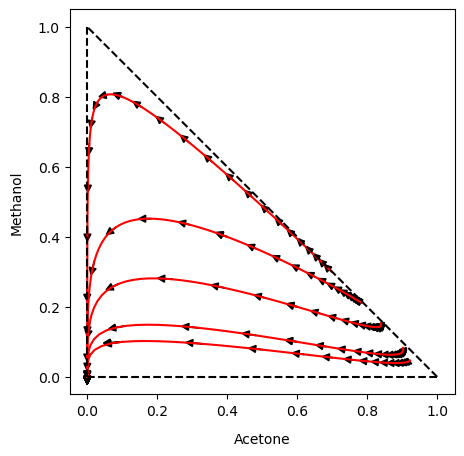

In [4]:
out_residue = Output()
rcm = PhasePortraits(thermo_model=AceMethWaterSys)
fig, ax = plt.subplots(1,1,figsize= (5,5))
rcm.plot_residue_curve(ax, [0,7],data_points = 100, 
                            init_comps = [ 
                                            np.array([0.4,0.4,0.2]),
                                            np.array([0.6,0.2,0.2]),
                                            np.array([0.6,0.1,0.3]),
                                            np.array([0.1,0.8,0.1]),
                                            np.array([0.1,0.1,0.8])
                                            ])
plt.show()

In [5]:
## RESIDUE CURVE FOR ETHANOL-WATER-ETHYLENE GLYCOL, HAS SOME OVERFLOW ##

# out_residue = Output()
# rcm = phase_portraits(thermo_model=AceMethWaterSys)
# fig, ax = plt.subplots(1,1,figsize= (7,7))
# rcm.plot_residue_curve(ax, [0,7],data_points = 100, 
                            # init_comps = [ 
                                            # np.array([0.4,0.4,0.2]),
                                            # np.array([0.6,0.2,0.2]),
                                            # np.array([0.6,0.1,0.3]),
                                            # np.array([0.1,0.8,0.1]),
                                            # np.array([0.1,0.1,0.8])
                                            # ])
# plt.show()

#### Create distillation models

### Demo 1.5: Comparing two Systems

Two systems are depicted in the graphs below.  Differences in the locations of the fixed points lead to different properties in the shapes of the operating curves.  These differences are highlighted at 3 sets of identical parameters:

A:  Notice how the middle section on the Acetone-Methanol-Water does not move in a direction that could connect the rectifying and stripping sections.  Instead, it curves upwards towards the saddle node, while the Ethanol-Water-Ethylene Glycol system is connected by its staple, resulting in a feasible column.

B: 

C:  Focus on the shapes of the Rectifying Sections.  The Acetone-Methanol-Water system is feasible because its rectifying section curves upwards and intersects the staple.  The Ethanol-Water-Ethylene Glycol system has a rectifying section with much fewer equilibrium stages, and it moves directly towards the stable Ethylene Glycol node.  As a result, the column is unfeasible

In [6]:
# Create an interactive plot function
def interactive_plot(system):
    if system == 'A':
        middle_start = 2
        Fr = 0.5
        R = 7

    if system == 'B':
        middle_start = 6
        R = 1.5     
        Fr = 1

    if system == 'C':
        middle_start = 9
        R = 1
        Fr = 2

    xFL = np.array([0.3, 0.6, 0.1])
    xFU = np.array([0.2, 0.1, 0.7])
    zF = (Fr/(1+Fr))*xFU + (1/(1+Fr))*xFL                                #Knapp Equation 5.9
    xD = np.array([0.90, 0.08, 0.02]) 
    D_B = ((zF[0] - 0.02) / (xD[0] - zF[0]))                             #Knapp Equation 5.13, set xB[0] = 0.01
    xB = np.array([0.02, (zF[1] - D_B*(xD[1]-zF[1])), (zF[2] - D_B*(xD[2]*zF[2]))])

    distillation_modelA = DistillationModelDoubleFeed(thermo_model=AceMethWaterSys, Fr = Fr, zF = zF, xFL = xFL, xFU = xFU, xD = xD, xB = xB, reflux = R)
    distillation_modelB = DistillationModelDoubleFeed(thermo_model=EthWaterEGSys, Fr = Fr, zF = zF, xFL = xFL, xFU = xFU, xD = xD, xB = xB, reflux = R)
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    distillation_modelA.plot_rect_strip_comp(axes[0], middle_start=middle_start)
    axes[0].set_title('Acetone-Methanol-Water')
    distillation_modelB.plot_rect_strip_comp(axes[1], middle_start=middle_start)
    axes[1].set_title('Ethanol-Water-Ethylene Glycol')

    plt.tight_layout()
    plt.show()


system_widget = widgets.Dropdown(
    options=["A", "B", "C"],
    description='Demo Choice:',
    disabled=False
    ) 

# Create an interactive plot with the dropdown widget
interactive(interactive_plot, system=system_widget)

interactive(children=(Dropdown(description='Demo Choice:', options=('A', 'B', 'C'), value='A'), Output()), _do…

#### Demo 2

In [7]:
# Create an interactive plot function
def interactive_plot(system, middle_start):
    thermo_choice = AceMethWaterSys
    Fr = 0.5
    R = 3
    if system == 'Ethanol/Water/Ethylene Glycol':
        thermo_choice = EthWaterEGSys
        Fr = 0.23
        R = 6
    xFL = np.array([0.3, 0.6, 0.1])
    xFU = np.array([0.2, 0.1, 0.7])
    zF = (Fr/(1+Fr))*xFU + (1/(1+Fr))*xFL                                #Knapp Equation 5.9
    xD = np.array([0.93, 0.04, 0.03]) 
    D_B = ((zF[0] - 0.02) / (xD[0] - zF[0]))                             #Knapp Equation 5.13, set xB[0] = 0.01
    xB = np.array([0.02, (zF[1] - D_B*(xD[1]-zF[1])), (zF[2] - D_B*(xD[2]*zF[2]))])

    distillation_model = DistillationModelDoubleFeed(thermo_model=thermo_choice, Fr = Fr, zF = zF, xFL = xFL, xFU = xFU, xD = xD, xB = xB, reflux = R)
    fig, ax = plt.subplots(1, 1, figsize=(5, 10))
    distillation_model.plot_rect_strip_comp(ax, middle_start=middle_start)
    plt.show()

# Create a dropdown widget for middle_start
middle_start_widget = widgets.Dropdown(
    options=[2, 4, 6, 8, 10],
    description='Middle Section Start:',
    disabled=False
)
system_widget = widgets.Dropdown(
    options=["Acetone/Methanol/Water","Ethanol/Water/Ethylene Glycol"],
    description='Components:',
    disabled=False
) 

# Create an interactive plot with the dropdown widget
interactive(interactive_plot, system=system_widget, middle_start=middle_start_widget)

interactive(children=(Dropdown(description='Components:', options=('Acetone/Methanol/Water', 'Ethanol/Water/Et…

### Demo 3
A maximum reflux ratio exists, around R=60?

In [11]:
R_slider =  widgets.FloatLogSlider(value=1, min=0, max=2, step=0.001,  description='Reflux Ratio:', readout_format='.1f')
go_button = widgets.Button(description='Create Model', width='15%', margin='0 10px 0 0')
system_widget = widgets.Dropdown(
    options=["Acetone/Methanol/Water","Ethanol/Water/Ethylene Glycol"],
    description='Components:',
    disabled=False
    ) 
# Create a dropdown widget for middle_start
middle_start_widget = widgets.Dropdown(
    options=[2, 4, 6, 8, 10],
    description='Middle Section Start:',
    disabled=False
)
out_middle = Output()

def plot_reflux_demo_ex5(R = R_slider, thermo_system = system_widget.value, middle_start=6):
    thermo_choice = AceMethWaterSys
    Fr = 1.0
    if thermo_system == 'Ethanol/Water/Ethylene Glycol':
        thermo_choice = EthWaterEGSys
        Fr = 0.1
    xFL = np.array([0.3, 0.6, 0.1])
    xFU = np.array([0.2, 0.1, 0.7])
    zF = (Fr/(1+Fr))*xFU + (1/(1+Fr))*xFL                                #Knapp Equation 5.9
    xD = np.array([0.93, 0.04, 0.03]) 
    D_B = ((zF[0] - 0.02) / (xD[0] - zF[0]))                             #Knapp Equation 5.13, set xB[0] = 0.01
    xB = np.array([0.02, (zF[1] - D_B*(xD[1]-zF[1])), (zF[2] - D_B*(xD[2]*zF[2]))])

    distillation_model = DistillationModelDoubleFeed(thermo_model = thermo_choice, Fr = Fr, zF = zF, xFL = xFL, xFU = xFU, xD = xD, xB = xB, reflux = R)
    fig, ax = plt.subplots(1,1,figsize= (5,10))
    distillation_model.plot_rect_strip_comp(ax, middle_start=middle_start)
    plt.subplots_adjust(hspace=0)
    plt.show()

def on_go_button_click(b):
    with out_middle:
        clear_output(wait=True)
        plt.close('all')  # Close all open matplotlib plots
        plot_reflux_demo_ex5(R=R_slider.value, thermo_system=system_widget.value, middle_start = middle_start_widget.value)
        
go_button = Button(description='Generate Plot')
go_button.on_click(on_go_button_click)

layout = VBox([system_widget,middle_start_widget, HBox([R_slider, go_button]), out_middle])
display(layout)

### Demo 4
Changing Feed Ratio

In [9]:
Fr_slider =  widgets.FloatLogSlider(value=0.64, min=-1, max=1, step=0.001,  description='Feed Ratio:', readout_format='.2f')
go_button = widgets.Button(description='Create Model', width='15%', margin='0 10px 0 0')
system_widget = widgets.Dropdown(
    options=["Acetone/Methanol/Water","Ethanol/Water/Ethylene Glycol"],
    description='Components:',
    disabled=False
    ) 
# Create a dropdown widget for middle_start
middle_start_widget = widgets.Dropdown(
    options=[2, 4, 6, 8, 10],
    description='Middle Section Start:',
    disabled=False
)
out_middle = Output()

def plot_reflux_demo_ex5_demo4(Fr = Fr_slider, thermo_system = system_widget.value, middle_start=6):
    thermo_choice = AceMethWaterSys
    R = 1.35
    if thermo_system == 'Ethanol/Water/Ethylene Glycol':
        thermo_choice = EthWaterEGSys
        R = 6
    xFL = np.array([0.3, 0.6, 0.1])
    xFU = np.array([0.2, 0.1, 0.7])
    zF = (Fr/(1+Fr))*xFU + (1/(1+Fr))*xFL                                #Knapp Equation 5.9
    xD = np.array([0.93, 0.04, 0.03]) 
    D_B = ((zF[0] - 0.02) / (xD[0] - zF[0]))                             #Knapp Equation 5.13, set xB[0] = 0.01
    xB = np.array([0.02, (zF[1] - D_B*(xD[1]-zF[1])), (zF[2] - D_B*(xD[2]*zF[2]))])

    distillation_model = DistillationModelDoubleFeed(thermo_model = thermo_choice, Fr = Fr, zF = zF, xFL = xFL, xFU = xFU, xD = xD, xB = xB, reflux = R)
    fig, ax = plt.subplots(1,1,figsize= (5,10))
    distillation_model.plot_rect_strip_comp(ax, middle_start=middle_start)
    plt.subplots_adjust(hspace=0)
    plt.show()


def on_go_button_click(b):
    with out_middle:
        clear_output(wait=True)
        plt.close('all')  # Close all open matplotlib plots
        plot_reflux_demo_ex5_demo4(Fr=Fr_slider.value, thermo_system=system_widget.value, middle_start = middle_start_widget.value)
        
go_button = Button(description='Generate Plot')
go_button.on_click(on_go_button_click)

layout = VBox([system_widget,middle_start_widget, HBox([Fr_slider, go_button]), out_middle])
display(layout)

Integration stopped due to overflow, NaN values, or out-of-bound values.
Integration stopped due to overflow, NaN values, or out-of-bound values.
Integration stopped due to overflow, NaN values, or out-of-bound values.
Integration stopped due to overflow, NaN values, or out-of-bound values.
Integration stopped due to overflow, NaN values, or out-of-bound values.
Integration stopped due to overflow, NaN values, or out-of-bound values.
Integration stopped due to overflow, NaN values, or out-of-bound values.
Integration stopped due to overflow, NaN values, or out-of-bound values.
Integration stopped due to overflow, NaN values, or out-of-bound values.
Integration stopped due to overflow, NaN values, or out-of-bound values.
Integration stopped due to overflow, NaN values, or out-of-bound values.
Integration stopped due to overflow, NaN values, or out-of-bound values.
Integration stopped due to overflow, NaN values, or out-of-bound values.
Integration stopped due to overflow, NaN values, or

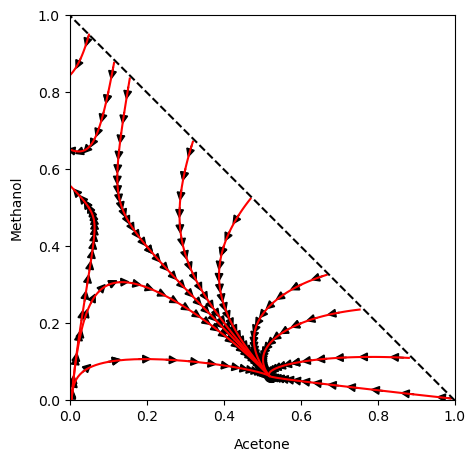

In [10]:
out_middle_phase_portrait = Output()

Fr  = 1.0
xFL = np.array([0.3, 0.6, 0.1])
xFU = np.array([0.2, 0.1, 0.7])
zF  = (Fr/(1+Fr))*xFU + (1/(1+Fr))*xFL                               #Knapp Equation 5.9
xD  = np.array([0.93, 0.04, 0.03]) 
D_B = ((zF[0] - 0.02) / (xD[0] - zF[0]))                             #Knapp Equation 5.13, set xB[0] = 0.01

xB = np.array([0.02, (zF[1] - D_B*(xD[1]-zF[1])), (zF[2] - D_B*(xD[2]*zF[2]))])
R = 3
distillation_model = DistillationModelDoubleFeed(thermo_model=AceMethWaterSys, Fr = Fr, zF = zF, xFL = xFL, xFU = xFU, xD = xD, xB = xB, reflux = R)
middle_portrait = PhasePortraits(thermo_model=AceMethWaterSys, distil_model=distillation_model)

fig, ax = plt.subplots(1,1,figsize= (5,5))
middle_portrait.plot_middle_portrait(ax, [0,7],data_points = 200, 
                            init_comps = [ 
                                            np.array([0.4,0.4,0.2]),
                                            np.array([0.6,0.2,0.2]),
                                            np.array([0.6,0.1,0.3]),
                                            np.array([0.1,0.8,0.1]),
                                            np.array([0.2,0.4,0.4]),
                                            np.array([0.1,0.1,0.8]),
                                            np.array([0.1,0.3,0.6]),
                                            np.array([0.3,0.6,0.1]),
                                            np.array([0.6,0.3,0.1]),
                                            np.array([0.99,0.005,0.005]),
                                            np.array([0.05,0.95,0.00]),
                                            np.array([0.05,0.5,0.45]),
                                            ])
plt.show()